# ANALYSIS
of CAHOOTS call volume & call types during extreme environmental events

In [2]:
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from datetime import date
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colormaps


# statistical tests:
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

In [3]:
clean_data = pd.read_csv('project-data/clean_cahoots_envs_data.csv')

clean_data.head()

,Date,inci_id,nature,AQI,AQI_Category,tempmax,tempmin,precip,snow,daily calls,extreme heat,extreme cold,snow event,ice event,AQI hazard
0,2014-01-01,14000107,TRANSPORT,122,Unhealthy for Sensitive Groups,39.0,30.0,0.0,0.0,24,0,0,0,0,0
1,2014-01-01,14000382,TRANSPORT,122,Unhealthy for Sensitive Groups,39.0,30.0,0.0,0.0,24,0,0,0,0,0
2,2014-01-01,14000408,TRANSPORT,122,Unhealthy for Sensitive Groups,39.0,30.0,0.0,0.0,24,0,0,0,0,0
3,2014-01-01,14000414,WELFARE CHECK,122,Unhealthy for Sensitive Groups,39.0,30.0,0.0,0.0,24,0,0,0,0,0
4,2014-01-01,14000416,SUBJECT DOWN,122,Unhealthy for Sensitive Groups,39.0,30.0,0.0,0.0,24,0,0,0,0,0


In [6]:
# MAKE SURE Date column in clean_data is DATETIME
if not pd.api.types.is_datetime64_any_dtype(clean_data['Date']):
    clean_data['Date'] = pd.to_datetime(clean_data['Date'])

# DAILY SUMMARY grouped dataframe
daily = clean_data.groupby('Date').agg({'daily calls': 'first', 'inci_id': 'first', 'extreme heat': 'max', 'extreme cold': 'min', 
                                      'snow': 'max', 'precip': 'max', 
                                      'snow event': 'max', 'ice event': 'max', 'AQI hazard': 'max',
                                      'tempmax': 'mean', 'tempmin': 'mean', 'AQI': 'mean'}).reset_index()

daily.head()

,Date,daily calls,inci_id,extreme heat,extreme cold,snow,precip,snow event,ice event,AQI hazard,tempmax,tempmin,AQI
0,2014-01-01,24,14000107,0,0,0.0,0.000,0,0,0,39.0,30.0,122.0
1,2014-01-02,21,14000811,0,0,0.0,0.000,0,0,0,49.4,34.1,80.0
2,2014-01-03,22,14001667,0,0,0.0,0.019,0,0,0,48.3,33.8,71.0
3,2014-01-04,20,14002413,0,1,0.0,0.000,0,0,0,39.4,26.7,77.0
4,2014-01-05,34,14003118,0,1,0.0,0.000,0,0,0,38.1,26.3,127.0


## 1. Time Series Overview

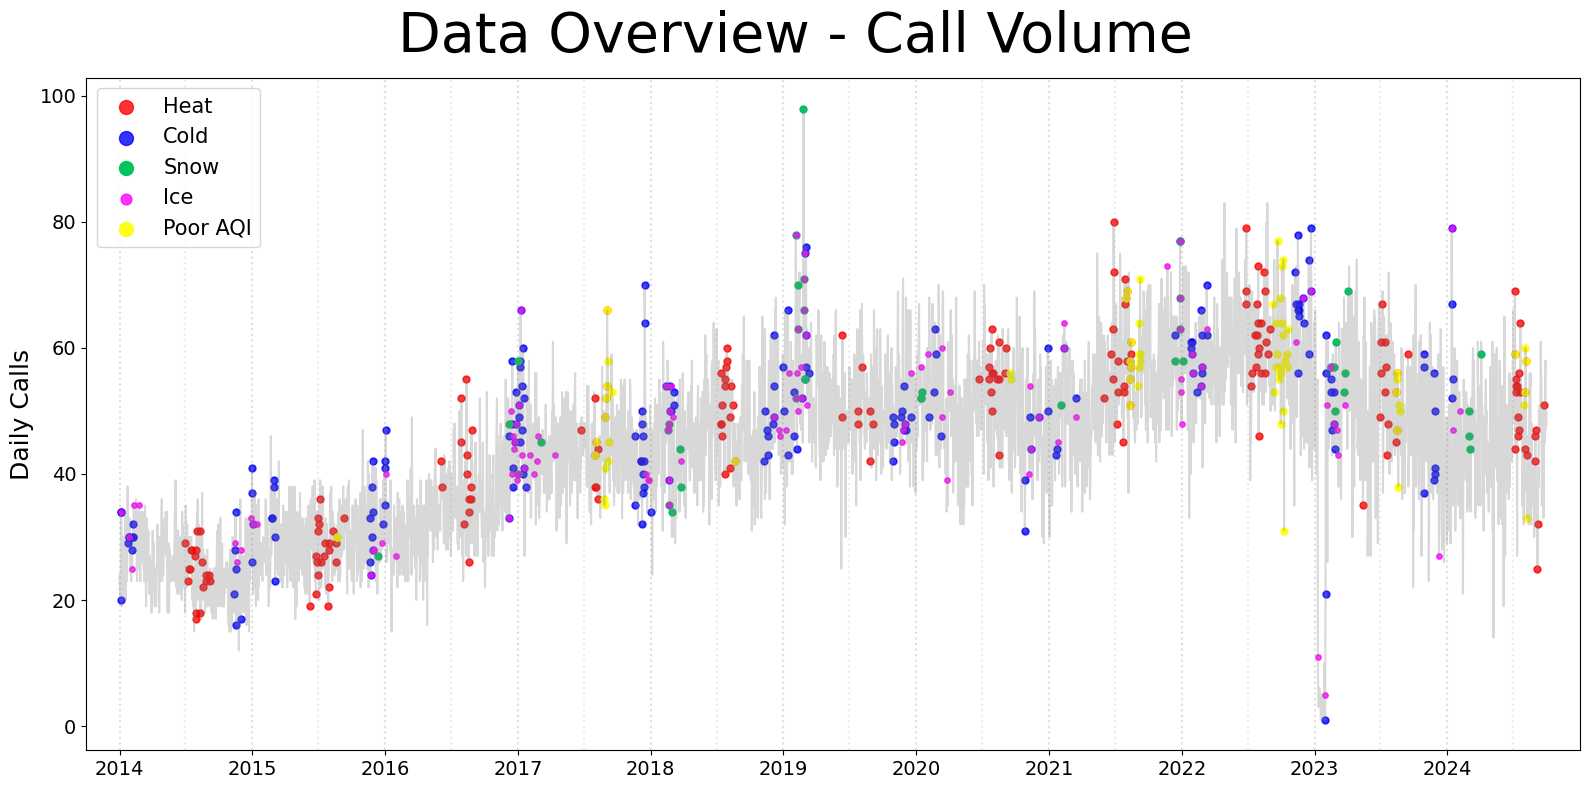

In [32]:
# TIME SERIES: daily calls, extreme events marked
fig, ax = plt.subplots(figsize=(16, 8))

plt.plot(daily['Date'], daily['daily calls'], color='gray', alpha=0.30)

# year separator lines
for year in range(2014, 2025):  # 2014 to 2024
    plt.axvline(x=date(year, 1, 1), color='gray', linestyle=':', alpha=0.25)
# half-year:
for year in range(2014, 2025):  # 2014 to 2024
    plt.axvline(x=date(year, 7, 1), color='gray', linestyle=':', alpha=0.15)

# markers for extreme events
plt.scatter(daily[daily['extreme heat'] == 1]['Date'], # heat
            daily[daily['extreme heat'] == 1]['daily calls'], 
            color='red', label='Heat', marker='o', s=25, alpha=0.8)

plt.scatter(daily[daily['extreme cold'] == 1]['Date'], # cold
            daily[daily['extreme cold'] == 1]['daily calls'], 
            color='blue', label='Cold', marker='o', s=25, alpha=0.8)

plt.scatter(daily[daily['snow event'] == 1]['Date'], # snowstorm
            daily[daily['snow event'] == 1]['daily calls'], 
            color='#02c45d', label='Snow', marker='o', s=25, alpha=1)

plt.scatter(daily[daily['ice event'] == 1]['Date'], # icestorm
            daily[daily['ice event'] == 1]['daily calls'], 
            color='#FF00FF', label='Ice', marker='o', s=15, alpha=0.8)

plt.scatter(daily[daily['AQI hazard'] == 1]['Date'], # aqi
            daily[daily['AQI hazard'] == 1]['daily calls'], 
            color='yellow', label='Poor AQI', marker='o', s=25, alpha=0.9)

# show year ticks on x axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # Format as '2020'

plt.suptitle('Data Overview - Call Volume', fontsize=40, color='Black')
# plt.title('CAHOOTS Call Volume & Environmental Events', fontsize=20, y=1.005)
#plt.xlabel('Year', fontsize=14, labelpad=10)
plt.xlim(date(2013, 10, 1), date(2024, 12, 31))
plt.ylabel('Daily Calls', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.legend(loc='upper left', 
          fontsize=15,
          markerscale=2,
          frameon=True,
          fancybox=True)

plt.tight_layout()
plt.savefig("timeseries.png", dpi=300)
plt.show()

## 2. CALL VOLUME Hypothesis testing: Is there a statistically significant difference between distributions of daily call volume during extreme vs. non extreme days for each type of environmental event?
### Using the **Mann Whitney U test**, because it:
- doesn't assume normal distributions
- works well with uneven sample sizes
- tests whether one group tends to have higher values than the other

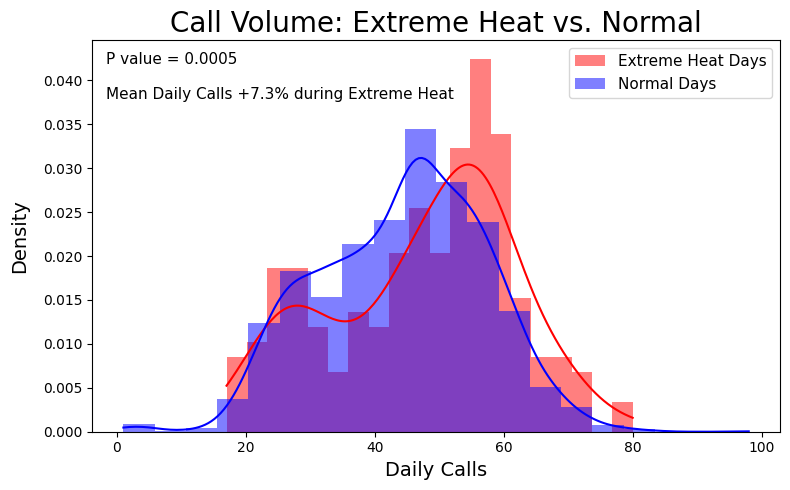

In [167]:
# function to do mann whitney u test for each environmental variable
def call_volume_test(daily_df, env_col):
    """
    Use Mann Whitney U test to analyze difference in call volume on days with vs. without an extreme environmental condition
    
    daily_df: dataframe grouped by day, with 'daily calls' column of total # calls/day
    env_col: the column name of the environmental condition to analyze ('extreme heat')
    """    
    # Split data
    normal = daily_df[daily_df[env_col] == 0].sort_values('Date')
    extreme = daily_df[daily_df[env_col] == 1].sort_values('Date')


    fig, ax = plt.subplots(figsize=(8, 5))

    # Histogram of the data groups
    sns.histplot(extreme['daily calls'], stat='density', kde=True, color='red', edgecolor='none', label=f'{env_col.title()} Days', bins=20, alpha=0.5)
    sns.histplot(normal['daily calls'], stat='density', kde=True, color='blue', edgecolor='none', label='Normal Days', bins=20, alpha=0.5)
    ax.set_xlabel('Daily Calls', fontsize=14)
    ax.set_ylabel('Density', fontsize=14, labelpad=10)
    ax.set_title(f'Call Volume: {env_col.title()} vs. Normal', fontsize=20)
    ax.legend(fontsize=11)

    # Mann-Whitney U Test
    statistic, p_value = mannwhitneyu(extreme['daily calls'], normal['daily calls'])

    # Mean calculations
    mean_extreme = extreme['daily calls'].mean()
    mean_normal = normal['daily calls'].mean()
    pct_change = (mean_extreme / mean_normal - 1) * 100

    # Annotation text & pvalue formatting:
    if env_col == 'AQI hazard':
        p_text = f"{p_value:.11f}"
    elif env_col == 'snow event':
        p_text = f"{p_value:.6f}"
    else:
        p_text = f"{p_value:.4f}"
        
    annotation_text = f"P value = {p_text}\n\nMean Daily Calls +{pct_change:.1f}% during {env_col.title()}"
    ax.text(
        0.02, 0.97, annotation_text,
        transform=ax.transAxes,  # relative to axes
        fontsize=11,
        verticalalignment='top',
        horizontalalignment='left',
        color='black'
    )

    plt.tight_layout()
    plt.savefig(f'{env_col.title().replace(" ", "")}Volume.png', dpi=300)  # remove spaces in filename
    plt.show()


# Run mann-whitney u test on each environmental variable:
# edited to just show a larger plot for Extreme Heat
envs = ['extreme heat']# 'extreme cold', 'snow event', 'ice event', 'AQI hazard']
for variable in envs:
    call_volume_test(daily, variable)

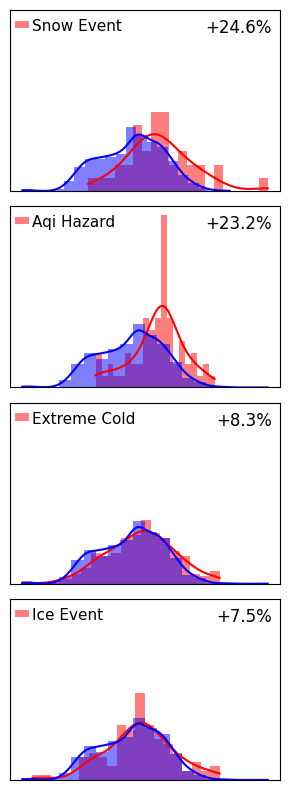

In [207]:
def smaller_call_volume_subplots(daily_df, env_vars):
    """
    make smaller subplots of call volume distributions during the rest of the extreme environmental conditions
    """
    fig, axes = plt.subplots(len(env_vars), 1, figsize=(3, 8), sharey=True)

    for ax, env_col in zip(axes, env_vars):
        normal = daily_df[daily_df[env_col] == 0]
        extreme = daily_df[daily_df[env_col] == 1]

        sns.histplot(extreme['daily calls'], stat='density', kde=True, color='red', edgecolor='none', bins=20, alpha=0.5, ax=ax)
        sns.histplot(normal['daily calls'], stat='density', kde=True, color='blue', edgecolor='none', bins=20, alpha=0.5, ax=ax)

        # small red legend patch inside axes
        box = patches.Rectangle((0.02, 0.9), 0.05, 0.04, transform=ax.transAxes,
                                facecolor='red', alpha=0.5, edgecolor='none')
        ax.add_patch(box)

        # Title text next to the box
        ax.text(0.08, 0.95, env_col.title(), transform=ax.transAxes, fontsize=11, va='top')

        # Calculate percent change
        mean_extreme = extreme['daily calls'].mean()
        mean_normal = normal['daily calls'].mean()
        pct_change = (mean_extreme / mean_normal - 1) * 100
        
        # Percent change written out
        ax.text(0.97, 0.95, f"+{pct_change:.1f}%", transform=ax.transAxes,
                fontsize=12, va='top', ha='right', color='black')
        
        # no ticks, labels, titles, legends
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
    
    plt.tight_layout()
    plt.savefig("SmallVolumeSubplots.png", dpi=300)
    plt.show()

# loop thru all except heat:
envs = ['snow event', 'AQI hazard', 'extreme cold', 'ice event']
smaller_call_volume_subplots(daily, envs)

### 2.1 Results:
- Small p-values indicate a statistically significant difference in call volume during every extreme environmental event (versus on normal days)
- Call volume always seems to be skewed slightly _higher_ during environmental events than on normal days.
- This statistically significant difference in volume doesn't necessarily give us much information about how crisis _needs_ / the _types of calls_ differ during these events.

## 3. CATEGORICAL Call Type Analysis: Is the proportion of specific call categories (out of total calls) significantly higher during specific environmental extremes? 

3.1: **General Visualizations of Call Type Makeup** & 3.2 **Chi-Squared Tests of Independence:** Do environmental extremes affect overall call type distributions?

3.3: **Z-Test for Proportions:** Do specific call types significantly increase/decrease during extreme events?

3.4: **Case Study Analysis:** Deep-dives into call types during the dataset’s most extreme weather events

### 3.1 General visualizations to compare the call type makeup across different extreme events:

In [172]:
# look at overall top call types
types = clean_data.groupby('nature').count()
types = types.sort_values('inci_id', ascending=False).head(10)
types

,Date,inci_id,AQI,AQI_Category,tempmax,tempmin,precip,snow,daily calls,extreme heat,extreme cold,snow event,ice event,AQI hazard
nature,,,,,,,,,,,,,,
PUBLIC ASSIST,57762,57762,57762,57762,57762,57762,57762,57762,57762,57762,57762,57762,57762,57762
WELFARE CHECK,50392,50392,50392,50392,50392,50392,50392,50392,50392,50392,50392,50392,50392,50392
TRANSPORT,31841,31841,31841,31841,31841,31841,31841,31841,31841,31841,31841,31841,31841,31841
SUICIDAL SUBJECT,10156,10156,10156,10156,10156,10156,10156,10156,10156,10156,10156,10156,10156,10156
INTOXICATED SUBJECT,3498,3498,3498,3498,3498,3498,3498,3498,3498,3498,3498,3498,3498,3498
DISORDERLY SUBJECT,2813,2813,2813,2813,2813,2813,2813,2813,2813,2813,2813,2813,2813,2813
TRAFFIC HAZARD,2617,2617,2617,2617,2617,2617,2617,2617,2617,2617,2617,2617,2617,2617
FOUND SYRINGE,2403,2403,2403,2403,2403,2403,2403,2403,2403,2403,2403,2403,2403,2403
ASSIST FIRE DEPARTMENT,1926,1926,1926,1926,1926,1926,1926,1926,1926,1926,1926,1926,1926,1926


<Figure size 1400x700 with 0 Axes>

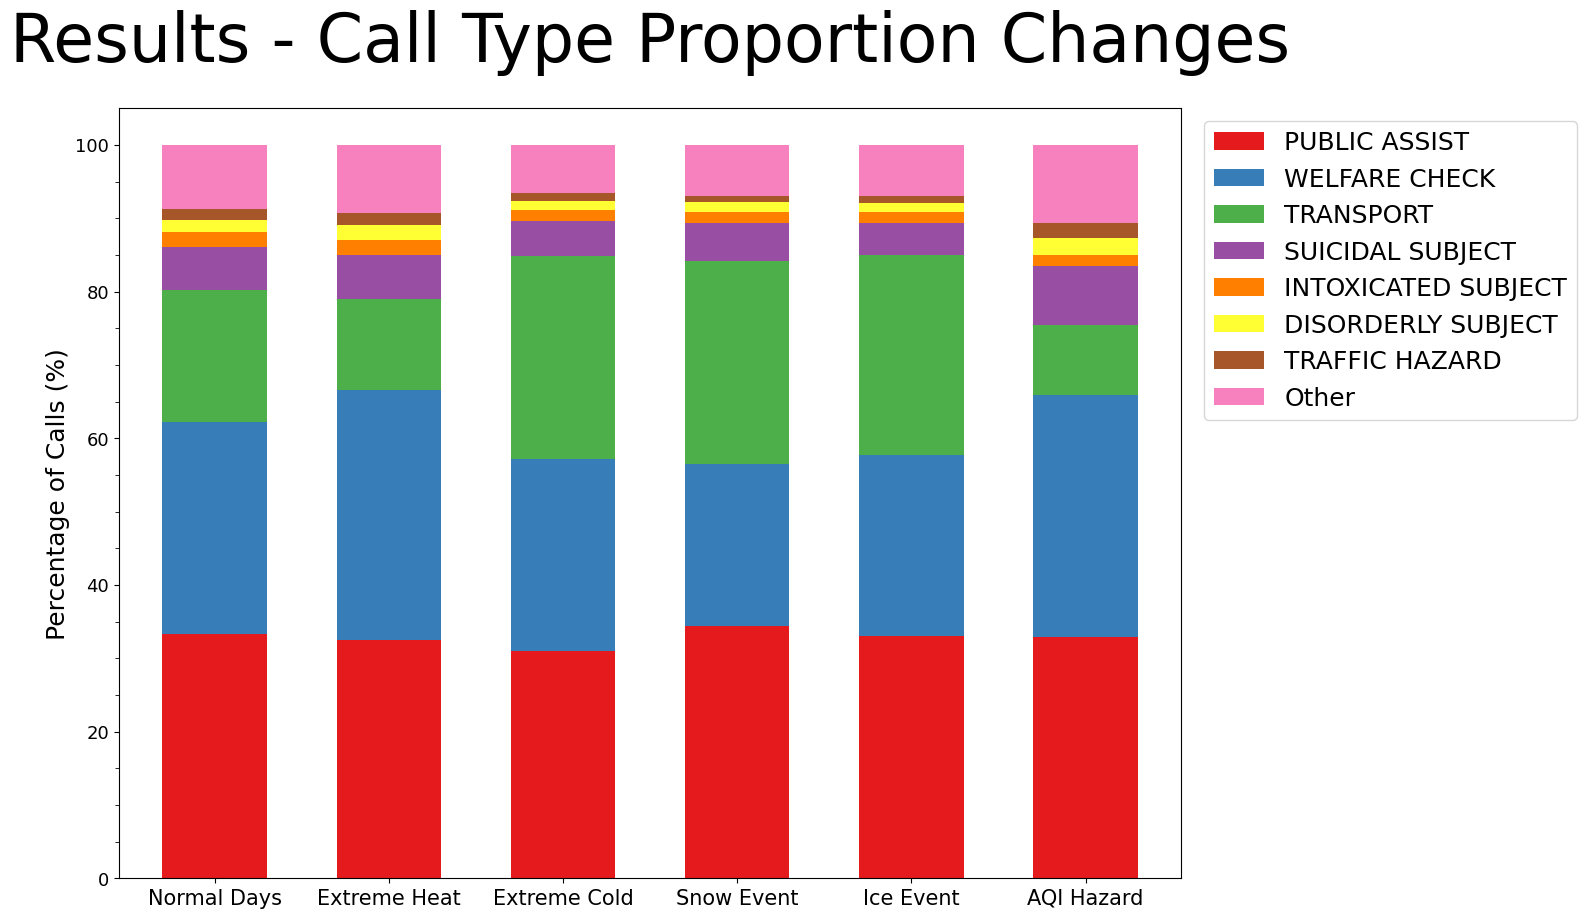

In [204]:
TOP_N = 7 # Number of top call types to show individually

# envs event columns & their display names
event_columns = ['extreme heat', 'extreme cold', 'snow event', 'ice event', 'AQI hazard']
display_names = ['Extreme Heat', 'Extreme Cold', 'Snow Event', 'Ice Event', 'AQI Hazard']

# Add "Normal" category at BEGINNING of list
event_columns_with_normal = event_columns.copy()
display_names_with_normal = display_names.copy()
event_columns_with_normal.insert(0,'normal')
display_names_with_normal.insert(0,'Normal Days')

# find overall top call types across all events
all_calls_count = clean_data['nature'].value_counts()
top_call_types = all_calls_count.nlargest(TOP_N).index.tolist()

# prepare data for plotting
results = {}
# Add "Normal" days category (where all events are 0)
normal_days = clean_data[(clean_data['extreme heat'] == 0) & 
                         (clean_data['extreme cold'] == 0) & 
                         (clean_data['snow event'] == 0) & 
                         (clean_data['ice event'] == 0) & 
                         (clean_data['AQI hazard'] == 0)]

normal_call_counts = {}
for call_type in top_call_types:
    count = len(normal_days[normal_days['nature'] == call_type])
    normal_call_counts[call_type] = count

# 'other' category for normal days
other_normal_calls = normal_days[~normal_days['nature'].isin(top_call_types)]
normal_call_counts['Other'] = len(other_normal_calls)

# Add normal days to results
results['normal'] = normal_call_counts


# For each environmental event
for event in event_columns:
    # Get calls during event
    event_calls = clean_data[clean_data[event] == 1]
    
    call_counts = {}
    # Count top call types
    for call_type in top_call_types:
        count = len(event_calls[event_calls['nature'] == call_type])
        call_counts[call_type] = count
    
    # 'other' category (all call types not in top_call_types)
    other_calls = event_calls[~event_calls['nature'].isin(top_call_types)]
    call_counts['Other'] = len(other_calls)
    
    # Store results
    results[event] = call_counts


plot_data = pd.DataFrame(results).T  # Transpose so events are rows (for plotting)

# STACKED BARPLOT: show PERCENTAGES instead of counts
plot_data_pct = plot_data.copy()
plot_data_pct = plot_data_pct.astype(float) # resolve datatype error
for idx in plot_data_pct.index: # go through each event category
    total = plot_data_pct.loc[idx].sum()
    plot_data_pct.loc[idx] = plot_data_pct.loc[idx] / total * 100.0

# PERCENTAGE stacked bar plot
plt.figure(figsize=(14, 7))
sns.set_palette("Set1", n_colors=len(plot_data_pct.columns))

ax2 = plot_data_pct.plot(kind='bar', stacked=True, figsize=(17, 10), width=0.6)

plt.title('Results - Call Type Proportion Changes', fontsize=48, y=1.05)
#plt.xlabel('Environmental Event', fontsize=16, labelpad=10)
plt.ylabel('Percentage of Calls (%)', fontsize=18)
plt.xticks(range(len(display_names_with_normal)), display_names_with_normal, rotation=0, ha='center', fontsize=15)

# legend outside the plot area
plt.legend(bbox_to_anchor=(1.01, 1), # Position to the right of the plot
          loc='upper left',
          fontsize=18,
          markerscale=2,
          frameon=True,
          fancybox=True)

plt.yticks(fontsize=13) # existing major ytick labels
ax2.set_yticks(range(0, 101, 5), minor=True) # minor ticks every 5%
ax2.tick_params(axis='y', which='minor', length=3) # minor ticks shorter
plt.subplots_adjust(right=0.75)  # Leave 25% space on right for legend
plt.savefig("stackedbars.png", dpi=300)
plt.show()

#### 3.1.1: findings from visualizations:

##### This bar chart above shows the percentage distribution of different call types during various types of environmental events & on normal days, based on data from the 11-year period.
##### It should be noted that there are more days classified as "Normal Days" than days with any extreme environmental event, so the total _raw number_ of calls on normal days is much higher.

##### From this visualization, we can see that the call types CAHOOTS most commonly responds to (no matter the weather conditions) are:
- PUBLIC ASSIST
- WELFARE CHECK
- TRANSPORT
- SUICIDAL SUBJECT
- INTOXICATED SUBJECT
- DISORDERLY SUBJECT
- TRAFFIC HAZARD
- the rest of the call categories are all small enough to be grouped together into an "other" category that makes up less than 10% of each bar's data

### 3.2 **Chi Squared Tests of Independence** to evaluate if there is an overall association between environmental extremes and call type distributions:
- The Chi-square test of independence: a statistical hypothesis test, determines whether two categorical variables are likely to be related or not.
- assumes independent observations, categorical data, and large enough sample sizes / intersections between categories (>5).
- In this case, the Chi squared test is testing this null hypothesis "There is _no association_ between the environmental condition (i.e. extreme heat) and the distribution of call categories"

In [46]:
def run_chi_square_test(data, condition_col, label):
    '''
    chi squared test of independence: to test relationship between categorical variables' distributions, for each environmental extreme

    data: data table
    condition_col: environmental conditions like extreme heat, etc.
    label: string for printing results

    Returns:
    observed counts of calltypes (contingency table)
    The expected counts under the assumption of independence
    prints:
    p-value degrees of freedom
    '''
    # Create contingency table: counts of each call type on extreme vs. non-extreme days
    contingency = pd.crosstab(data['nature'], data[condition_col])

    # do Chi2 test of independence
    # print table shape and min expected count check (chi2 assumptions)
    chi2, p, dof, expected = chi2_contingency(contingency)
    expected_df = pd.DataFrame(expected, index=contingency.index, columns=contingency.columns)
    # Check assumptions
    min_expected = expected_df.min().min()
    too_small = (expected_df < 5).sum().sum()

    # print results & return dataframe
    print(f"{label.title()}: p-value of {p}\n")
    return contingency, expected_df

# Run chi2 test for each environmental event / extreme
print(f"Chi-Square Test Results:\n")
for cond, name in zip(['extreme heat', 'extreme cold', 'snow event', 'ice event', 'AQI hazard'],
                      ['Extreme Heat', 'Extreme Cold', 'Snow', 'Ice', 'Poor Air Quality']):
    run_chi_square_test(clean_data, cond, name)

Chi-Square Test Results:

Extreme Heat: p-value of 8.230583441825576e-49

Extreme Cold: p-value of 1.3099974744424027e-79

Snow: p-value of 1.0254507853850715e-07

Ice: p-value of 1.685626296481515e-45

Poor Air Quality: p-value of 1.935900754097227e-46



#### 3.2.1 findings from Chi Squared tests:
Extremely small p-values indicate that **the distribution of call categories changes significantly** during environmental extremes compared to normal days.


### 3.3 **Z-tests for proportions:** Test whether the proportion of _specific_ call types differs significantly between extreme-weather days and normal days, and report _how much_ it changed
- a Z-test is a statistical test for comparing the proportions from two populations, to see if the difference between them is statistically significant (outputs a p value)
- How it works: Calculates the absolute difference between the proportion of the call type during extreme & normal days, and determines whether that difference is likely due to chance based on the 2 sample sizes.
- For example, "Is the proportion of welfare check calls significantly higher during extreme heat? Can this be attributed to random chance?"
- A Z-test assumes independent, categorical observations across two groups 
#### Note: I will be evaluating the % changes of the **smaller subset of call types** (listed above) which are the most common across all the data-- on "normal" days and environmentally extreme days alike. This is because uncommon call types, even if they do change by a "significant" amount, are still extremely rare as shown in the bar chart above.

In [48]:
# test & print results for significance comparison of a single calltype and a single environmental event type
def test_call_type_proportion(data, call_type, env_condition_col, alpha=0.05):
    """
    Run z-test to see if the proportion of a specific call type changes during an environmental event
    
    data: clean_data
    call_type: call type to test
    env_condition_col: environmental condition column name
    alpha: significance level (p-value cutoff = 0.05)
    
    Returns dict with stats: counts, proportions, p-value, and significance
    """
    # filter for extreme days vs normal days
    extreme = data[data[env_condition_col] == 1]
    normal = data[data[env_condition_col] == 0]
    
    # Counts of the specific call type
    extreme_count = (extreme['nature'] == call_type).sum()
    normal_count = (normal['nature'] == call_type).sum()
    
    # Total calls (for calculating proportion)
    extreme_total = len(extreme)
    normal_total = len(normal)
    
    # proportions
    extreme_prop = extreme_count / extreme_total
    normal_prop = normal_count / normal_total
    
    # Z-test
    count = np.array([extreme_count, normal_count])
    nobs = np.array([extreme_total, normal_total])
    stat, p_value = proportions_ztest(count, nobs)
    
    # % change
    pct_change = ((extreme_prop / normal_prop) - 1) * 100 if normal_prop > 0 else np.nan
    
    return {
        'call_type': call_type,
        'env_condition': env_condition_col,
        'extreme_proportion': extreme_prop,
        'normal_proportion': normal_prop,
        'extreme_count': extreme_count,
        'normal_count': normal_count,
        'extreme_total': extreme_total,
        'normal_total': normal_total,
        'p_value': p_value,
        'significant': p_value < alpha,
        'pct_change': pct_change, 
        'percentage_point_diff': (extreme_prop - normal_prop) * 100, # measure the change in the composition of calls (the distribution shift)
        'extreme_prop_pct': extreme_prop * 100, # for clearer reporting !!! (i use this in visualizations)
        'normal_prop_pct': normal_prop * 100
    }


# function to print the results
def print_ztest_results(results):
    change_direction = "increases" if results['pct_change'] > 0 else "decreases"
    
    print(f"Call type: {results['call_type']} during {results['env_condition']} days:")
    print(f"  Normal days: {results['normal_count']} calls out of {results['normal_total']} ({results['normal_prop_pct']:.2f}% of all calls)")
    print(f"  {results['env_condition']} days: {results['extreme_count']} calls out of {results['extreme_total']} ({results['extreme_prop_pct']:.2f}% of all calls)")
    print(f"  Change: {results['percentage_point_diff']:.2f} percentage points ({results['pct_change']:.1f}% relative change)")
    print(f"  p-value: {results['p_value']} - {'Significant' if results['significant'] else 'Not significant'}\n")

### 3.3.1 Visualization of Z-test results: % change in the proportion of specific call types during extreme environmental events:

In [181]:
# pct_change or percentage_point_diff represent different interpretations of cal type "change"

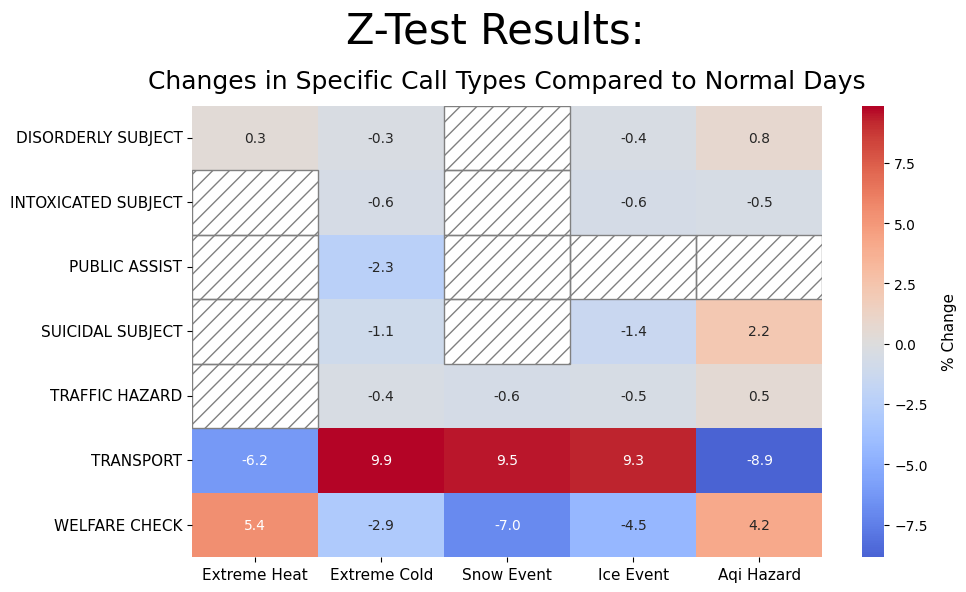

In [58]:
# list of call types and environmental conditions
call_types = ['PUBLIC ASSIST', 'WELFARE CHECK', 'TRANSPORT', 'SUICIDAL SUBJECT', 'INTOXICATED SUBJECT', 'DISORDERLY SUBJECT', 'TRAFFIC HAZARD']
env_conditions = ['extreme heat', 'extreme cold', 'snow event', 'ice event', 'AQI hazard']

# run tests & collect the results
results = []

for call_type in call_types:
    for env_condition in env_conditions:
        # run z-test for significance
        result = test_call_type_proportion(clean_data, call_type, env_condition)
        
        # store entire result
        results.append({
            'call_type': call_type,
            'env_condition': env_condition,
            'percentage_point_diff': result['percentage_point_diff'], # or pct_change
            'significant': result['significant']
        })
            

# pivot to create heatmap matrix
results_df = pd.DataFrame(results)
matrix_df = results_df.pivot(index='call_type', columns='env_condition', values='percentage_point_diff')
significance_matrix = results_df.pivot(index='call_type', columns='env_condition', values='significant')

# Convert to numeric to handle errors
matrix_df = matrix_df.apply(pd.to_numeric, errors='coerce')

# put columns in custom order
order = ['extreme heat', 'extreme cold', 'snow event', 'ice event', 'AQI hazard']
matrix_df = matrix_df[order]
significance_matrix = significance_matrix[order]
matrix_df.columns = matrix_df.columns.str.title()
significance_matrix.columns = significance_matrix.columns.str.title()

# PLOT HEATMAP:
plt.figure(figsize=(10, 6))
mask = ~significance_matrix # MASK to block out non-significant values
ax = sns.heatmap(matrix_df, 
                annot=True,
                fmt=".1f",
                cmap='coolwarm',
                center=0,
                mask=mask, # Mask non-significant values
                cbar_kws={'label': 'Percentage Change (%)'})

# colorbar customization
cbar = ax.collections[0].colorbar
cbar.set_label('% Change', labelpad=10, fontsize=11)

# shading for non-significant results
for i in range(len(call_types)):
    for j in range(len(env_conditions)):
        if mask.iloc[i, j]:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='gray', 
                                      lw=1, hatch='//'))

plt.suptitle('Z-Test Results:', fontsize=30)
plt.title('Changes in Specific Call Types Compared to Normal Days', fontsize=18, y=1.02)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.savefig("calltypes_heatmap.png", dpi=300)
plt.show()

### 3.3.2 Findings from Z-tests, & Percent Change Interpretation:

TRANSPORT and WELFARE CHECK calls change the most during extreme weather events.

-Transport needs increase during cold/ice/snow

-Welfare check needs increase during heat/poor air quality.


PERCENTAGE POINT CHANGE METRIC:
- Percentage point change is the absolute difference between two percentages.
- Relative percentage change shows how much the original percentage has increased or decreased relative to itself.

EXAMPLE - WELFARE CHECK during AQI Hazard Days:
- During Poor AQI, welfare check calls make up an additional 4.16% of _all calls_ (a shift in the overall composition) - percentage point change
- The proportion of welfare check calls during poor AQI is 14.4% higher than itself on normal days (about 1.1 times more common) - relative % change

### 3.4 Examining **case studies** of the most extreme environmental events:

Plot call type percentage point changes to get a comprehensive overview of how crisis call categories changed during these particular events.

I am looking at extreme heat, extreme cold, snow, and aqi hazards, because ice storms are a variable I engineered myself and thus there isn't a continuous 'ice storm' variable to find the most extreme occurence of.

These are just visualizations of changes, and statistical significance isn't taken into account.

In [209]:
# use the same process as in the functions above to calculate the statistics,
# and then make the big barplot of the 5 most severe events

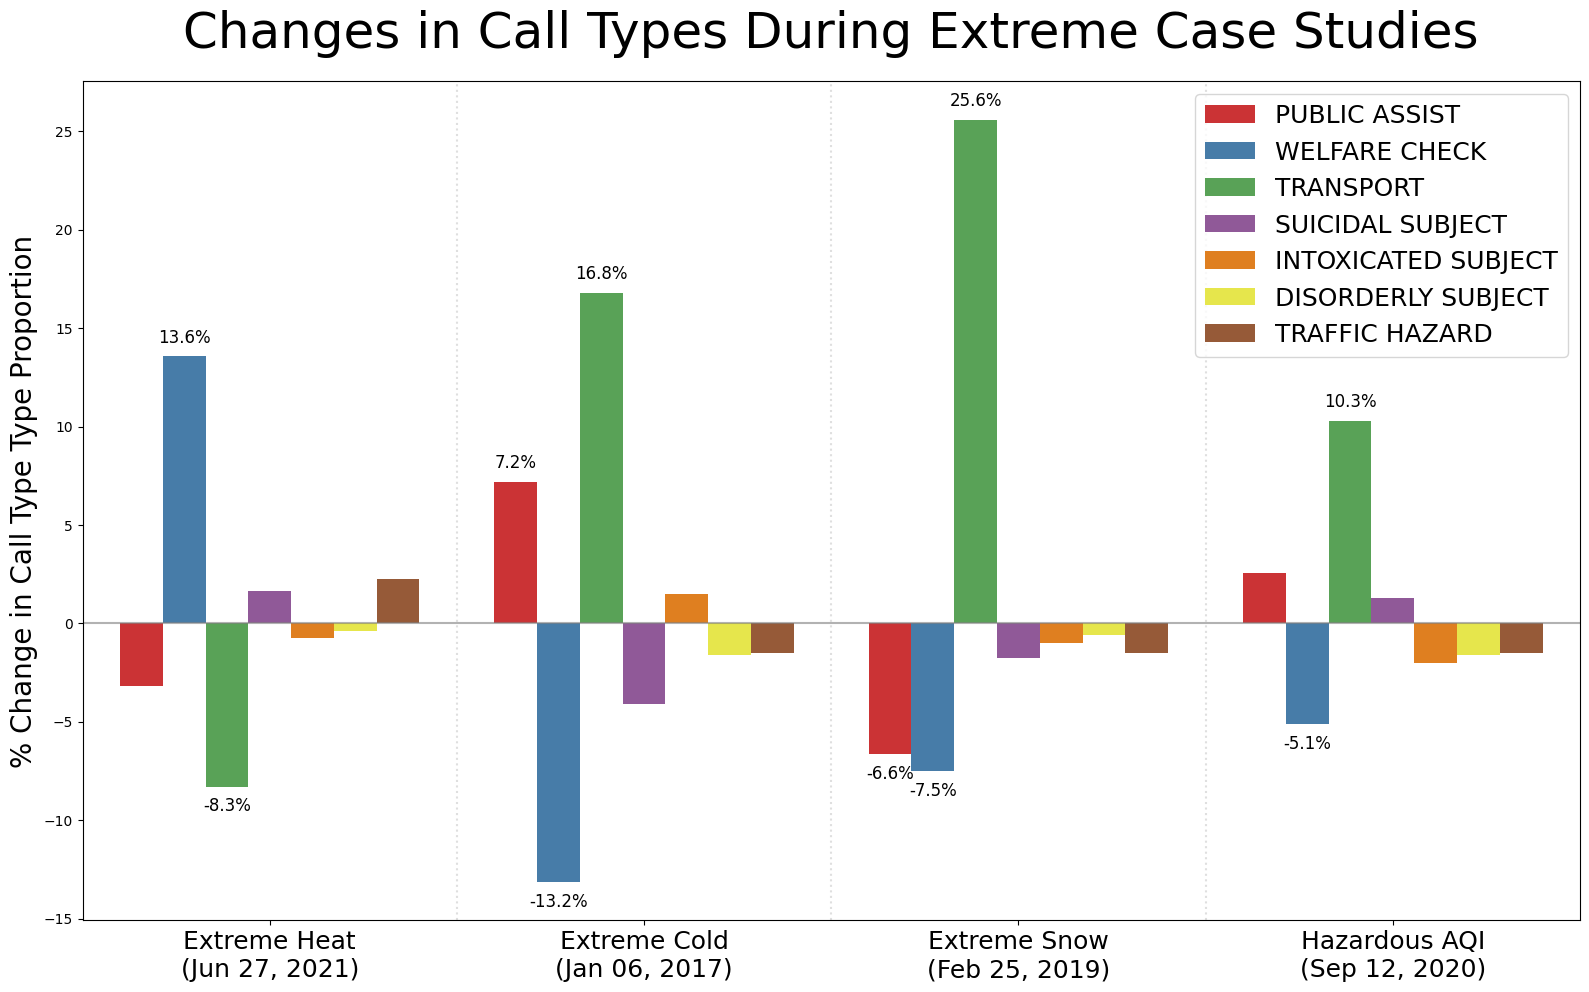

In [194]:
# Find the most extreme days
heat_date = daily.loc[daily['tempmax'].idxmax(), 'Date']
cold_date = daily.loc[daily['tempmin'].idxmin(), 'Date'] 
snow_date = daily.loc[daily['snow'].idxmax(), 'Date']
aqi_date = daily.loc[daily['AQI'].idxmax(), 'Date']

# Call types to analyze
call_types = ['PUBLIC ASSIST', 'WELFARE CHECK', 'TRANSPORT', 'SUICIDAL SUBJECT', 'INTOXICATED SUBJECT', 'DISORDERLY SUBJECT', 'TRAFFIC HAZARD']

# results to plot
results = []

for event_name, event_date in [('Extreme Heat', heat_date), 
                               ('Extreme Cold', cold_date),
                               ('Extreme Snow', snow_date), 
                               ('Hazardous AQI', aqi_date)]:
    
    # get data for that day vs all other days
    event_day = clean_data[clean_data['Date'] == event_date]
    other_days = clean_data[clean_data['Date'] != event_date]
    
    for call_type in call_types:
        # Calculate proportions
        event_prop = (event_day['nature'] == call_type).mean()
        normal_prop = (other_days['nature'] == call_type).mean()
        
        # Calculate percentage point difference
        pct_point_diff = (event_prop - normal_prop) * 100
        
        # Add to results
        results.append({
            'event': event_name,
            'call_type': call_type,
            'percentage_point_diff': pct_point_diff,
            'event_date': event_date})

results_df = pd.DataFrame(results)

# PLOT
plt.figure(figsize=(16, 10))
sns.set_palette("Set1", n_colors=len(plot_data_pct.columns))
ax = sns.barplot(x='event', y='percentage_point_diff', hue='call_type', data=results_df, width=0.8)

# Format dates for labels
event_dates_formatted = {
    'Extreme Heat': heat_date.strftime('%b %d, %Y'),
    'Extreme Cold': cold_date.strftime('%b %d, %Y'),
    'Extreme Snow': snow_date.strftime('%b %d, %Y'),
    'Hazardous AQI': aqi_date.strftime('%b %d, %Y')
}

# x axis labels
x_labels = [f"{event}\n({event_dates_formatted[event]})" for event in results_df['event'].unique()]
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, fontsize=18)

plt.title('Changes in Call Types During Extreme Case Studies', fontsize=36, y=1.03)
plt.xlabel('')
plt.ylabel('% Change in Call Type Type Proportion', fontsize=20)
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.6)

# year separator lines
for i in range(1, 4):
    plt.axvline(x=i-0.5, color='gray', linestyle=':', alpha=0.25)

plt.legend(loc='best', fontsize=18, markerscale=2, frameon=True, fancybox=True)

# labels on bars
for bar in ax.patches:
    if abs(bar.get_height()) > 5:
        ax.text(
            bar.get_x() + bar.get_width()/2.,
            bar.get_height() + (0.7 if bar.get_height() > 0 else -1.25),
            f'{bar.get_height():.1f}%',
            ha='center', fontsize=12
        )

plt.tight_layout()
plt.savefig("casestudies.png", dpi=300)
plt.show()

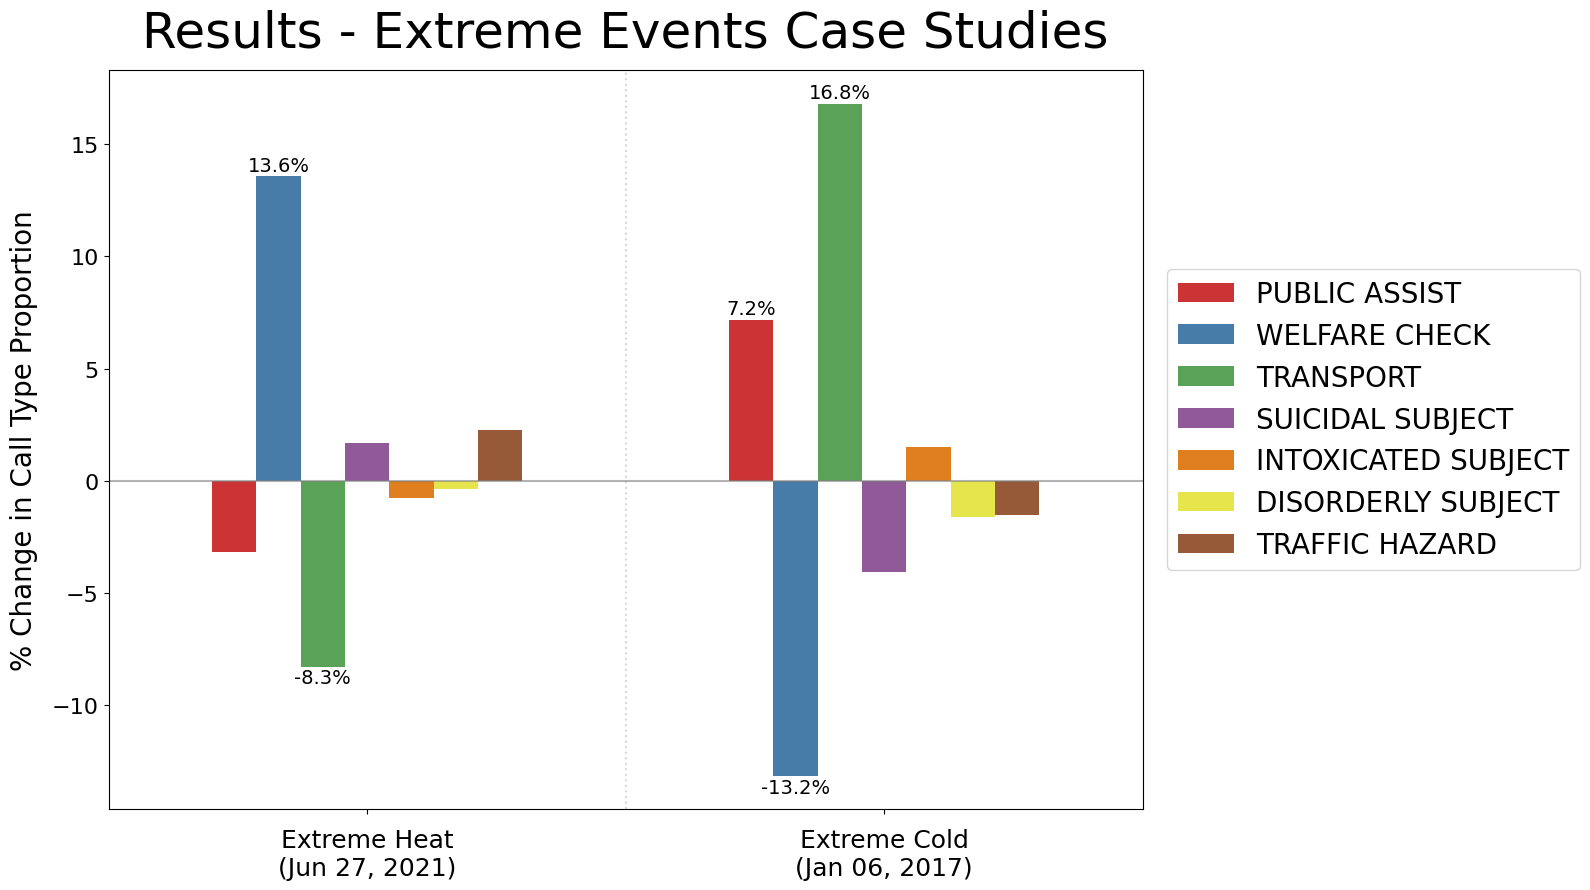

In [211]:
# another, smaller plot with just 2 events: for my presentation slideshow
# Find the most extreme days
heat_date = daily.loc[daily['tempmax'].idxmax(), 'Date']
cold_date = daily.loc[daily['tempmin'].idxmin(), 'Date'] 
snow_date = daily.loc[daily['snow'].idxmax(), 'Date']
aqi_date = daily.loc[daily['AQI'].idxmax(), 'Date']

# Call types to analyze
call_types = ['PUBLIC ASSIST', 'WELFARE CHECK', 'TRANSPORT', 'SUICIDAL SUBJECT', 'INTOXICATED SUBJECT', 'DISORDERLY SUBJECT', 'TRAFFIC HAZARD']

# results to plot
results = []

for event_name, event_date in [('Extreme Heat', heat_date), 
                               ('Extreme Cold', cold_date)]:
    
    # get data for that day vs all other days
    event_day = clean_data[clean_data['Date'] == event_date]
    other_days = clean_data[clean_data['Date'] != event_date]
    
    for call_type in call_types:
        # Calculate proportions
        event_prop = (event_day['nature'] == call_type).mean()
        normal_prop = (other_days['nature'] == call_type).mean()
        
        # Calculate percentage point difference
        pct_point_diff = (event_prop - normal_prop) * 100
        
        # Add to results
        results.append({
            'event': event_name,
            'call_type': call_type,
            'percentage_point_diff': pct_point_diff,
            'event_date': event_date})

results_df = pd.DataFrame(results)

# PLOT
plt.figure(figsize=(16, 9))
sns.set_palette("Set1", n_colors=len(plot_data_pct.columns))
ax = sns.barplot(x='event', y='percentage_point_diff', hue='call_type', data=results_df, width=0.6)

# Format dates for labels
event_dates_formatted = {
    'Extreme Heat': heat_date.strftime('%b %d, %Y'),
    'Extreme Cold': cold_date.strftime('%b %d, %Y')
}

# x axis labels
x_labels = [f"{event}\n({event_dates_formatted[event]})" for event in results_df['event'].unique()]
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, fontsize=18)
ax.tick_params(axis='x', pad=10)
# y axis
ax.tick_params(axis='y', labelsize=16)

plt.title('Results - Extreme Events Case Studies', fontsize=36, y=1.02)
plt.xlabel('')
plt.ylabel('% Change in Call Type Proportion', fontsize=20, labelpad=10)
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.6)

# year separator lines
for i in range(2):
    plt.axvline(x=i-0.5, color='gray', linestyle=':', alpha=0.3)

plt.legend(bbox_to_anchor=(1.01, 0.75), # to the right of the plot
          loc='upper left',
          fontsize=20,
          markerscale=2,
          frameon=True,
          fancybox=True)

# labels on bars
for bar in ax.patches:
    if abs(bar.get_height()) > 5:
        ax.text(
            bar.get_x() + bar.get_width()/2.,
            bar.get_height() + (0.25 if bar.get_height() > 0 else -.75),
            f'{bar.get_height():.1f}%',
            ha='center', fontsize=14
        )

plt.subplots_adjust(right=0.75)  # Leave 25% space on right for legend
plt.tight_layout()
plt.savefig("casestudies_simple.png", dpi=300)
plt.show()

### 3.4.1 Findings from Case Studies

Generally the same patterns as found using the z-tests on the entire dataset:
- Transport calls increase during cold-weather events
- Welfare check calls increase during extreme heat

There are some differences: increased transport needs during Hazardous AQI in Sep 2020, increased public assist needs during extreme cold in Jan 2017 (but GENERALLY THE SAME PATTERNS).

## 3.5 Summary of ALL Categorical Analysis Results/Findings:

My stacked barplot visualizations gave a general overview of the proportions of different call types during each type of extreme environmental event (vs. normal days). Overall, across all event types, the most common call types were: PUBLIC ASSIST, WELFARE CHECK, TRANSPORT, SUICIDAL SUBJECT, INTOXICATED SUBJECT, DISORDERLY SUBJECT, and TRAFFIC HAZARD (the rest of the call types made up <10% of calls).

A Chi-Square Test of Independence was conducted to determine whether the distribution of call categories differed between normal days and extreme environmental conditions. Results showed statistically significant _differences in call type distributions_ for ALL: extreme heat, extreme cold, snow, ice, and poor air quality (p < 0.001 for all). This suggests that certain types of calls become more or less frequent during these environmental extremes, & it is not due to random chance.

Then, I used z-tests to test whether the proportion of specific call types significantly changed during extreme-weather days compared to normal days. I looped through the call types during each type of environmental event, and found that many of them significantly changed (p<0.05). I plotted a heatmap of the 7 most common call types during each of the 5 environmental extremes, which shows the percentage point change in each call type's proportion during that event, and grays out all the statistically insignificant changes.
- TRANSPORT and WELFARE CHECK calls changed the most: TRANSPORT increased during cold-weather events and WELFARE CHECK increased during heat/poor AQI.

Lastly, in analyzing and visualizing the % changes in call types during the dataset's 5 most extreme environmental events (case studies), I found similar results to those above.